In [1]:
import numpy as np
import pickle
import sys
import sklearn as sk
from sklearn.linear_model import LinearRegression
sys.path.append('gan')
import matplotlib
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from sklearn.kernel_ridge import KernelRidge
import torch
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

# Importing the Data (NPZ)

In WWT, For Training and Testing Datasets, each has


50_000 samples, each of 550 timestamp, each timestamp has only one measurement --> (The # of page views (View Counter))

In [2]:
# Each has three arrays: data_feature,data_attribute,data_gen_flag 
training_real = np.load('../data/web/data_train.npz')
test_real = np.load('../data/web/data_test.npz')
training_DG = np.load('../data_generated/web/generated_data_train.npz')

In [3]:
##############################################REAL#################################################
# Y here means the data that we are going to forecast it
real_train_X = training_real['data_feature'][:,:500]
real_train_Y = training_real['data_feature'][:,500:]

real_test_X = test_real['data_feature'][:,:500]
real_test_Y = test_real['data_feature'][:,500:]

In [4]:
training_DG = np.load('../data_generated/web/generated_data_train.npz')
TST = np.load('WWT_generated_new.npz')
#########################################DG#################################################
DG_X =  training_DG['data_feature'][:,:500]
DG_Y =  training_DG['data_feature'][:,500:]

#########################################TST#################################################
TST_X = TST['X'][:,:500]
TST_Y = TST['X'][:,500:]

In [7]:
combined_TST_X = np.concatenate((real_train_X,TST_X))
combined_TST_Y = np.concatenate((real_train_Y,TST_Y))

In [103]:
del combined_TST_X
del combined_TST_Y

In [5]:
combined_DG_X = np.concatenate((real_train_X,DG_X))
combined_DG_Y = np.concatenate((real_train_Y,DG_Y))

In [47]:
##############################PREPARE FOR SKLEARN##############################
#1- Flatten all the feature arrays
#2- Convert all the One HOT Encoding into labels
with tf.device('/CPU:0'):
    real_train_Y_sk = keras.layers.Flatten(input_shape=(500, 1))(real_train_Y)
    real_test_Y_sk = keras.layers.Flatten(input_shape=(500, 1))(real_test_Y)
    
    real_train_X_sk = keras.layers.Flatten(input_shape=(500, 1))(real_train_X)
    real_test_X_sk = keras.layers.Flatten(input_shape=(500, 1))(real_test_X)
    
#     DG_X_sk = keras.layers.Flatten(input_shape=(500, 1))(DG_X)
#     DG_Y_sk = keras.layers.Flatten(input_shape=(500, 1))(DG_Y)
   
    TST_X_sk =  keras.layers.Flatten(input_shape=(500, 1))(TST_X)
    TST_Y_sk =  keras.layers.Flatten(input_shape=(500, 1))(TST_Y)

    combined_TST_X_sk =  keras.layers.Flatten(input_shape=(500, 1))(combined_TST_X)
    combined_TST_Y_sk =  keras.layers.Flatten(input_shape=(500, 1))(combined_TST_Y)
    
    
    combined_DG_X_sk =  keras.layers.Flatten(input_shape=(500, 1))(combined_DG_X)
    combined_DG_Y_sk =  keras.layers.Flatten(input_shape=(500, 1))(combined_DG_Y)

# Custom R2-score metrics for keras backend

In [7]:
# custom R2-score metrics for keras backend
from tensorflow.keras import backend as K
# https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/34019
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - (SS_res/SS_tot) )



In [8]:
mlp1layer = keras.Sequential([
    #Take the first 500 Timestamps/days and flatten them into a 1-D vector
    keras.layers.Flatten(input_shape=(500, 1)),
    #One Hidden Layer with 100 nodes as speicif in the Appendix(D)
    keras.layers.Dense(100,activation='relu'),
    #Output 50 values for 50 feature days
    keras.layers.Dense(50)
])

callback = tf.keras.callbacks.EarlyStopping(monitor='r2_score', patience=2,mode='max')

mlp1layer.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error',
                    metrics=['mean_squared_error',r2_score])

#Training using the generated data
mlp1layer.fit(TST_X,TST_Y,epochs=100,batch_size=64,callbacks=[callback])

Epoch 1/100
782/782 [==============================] - 2s 2ms/step - loss: 0.0590 - mean_squared_error: 0.0590 - r2_score: 0.7812
Epoch 2/100
294/782 [==========>...................] - ETA: 1s - loss: 2.3064e-04 - mean_squared_error: 2.3064e-04 - r2_score: 0.9992

KeyboardInterrupt: 

In [31]:
#Testing using the real data
results = mlp1layer.evaluate(real_test_X,real_test_Y,verbose=1,batch_size=512)

98/98 [==============================] - 0s 2ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - r2_score: 0.8092


In [32]:
# New TST has MSE of 0.0106 (1mlp) and 0.0095 (5mlp)
# Old TST has MSE of 0.0107 (1mlp) and 0.0100 (5mlp)

In [43]:
mlp5layer = keras.Sequential([
    keras.layers.Flatten(input_shape=(500, 1)),
    keras.layers.Dense(200,activation='relu'),
    keras.layers.Dense(200,activation='relu'),
    keras.layers.Dense(200,activation='relu'),
    keras.layers.Dense(200,activation='relu'),
    keras.layers.Dense(200,activation='relu'),
    keras.layers.Dense(50)
])

mlp5layer.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error',
                    metrics=['mean_squared_error',r2_score])
mlp5layer.fit(TST_X,TST_Y,epochs=100,batch_size=64,callbacks=[callback])

Epoch 1/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0345 - mean_squared_error: 0.0345 - r2_score: 0.8648
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 2.4879e-04 - mean_squared_error: 2.4879e-04 - r2_score: 0.9990
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 2.0910e-04 - mean_squared_error: 2.0910e-04 - r2_score: 0.9993
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 9.4927e-05 - mean_squared_error: 9.4927e-05 - r2_score: 0.9997
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: 6.6421e-05 - mean_squared_error: 6.6421e-05 - r2_score: 0.9997
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 2.0714e-04 - mean_squared_error: 2.0714e-04 - r2_score: 0.9993
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 9.3404e-05 - mean_squared_error: 9.3404e-05 - r2_score: 0.9997
Epoch 8/10
782/782 [=============================

In [44]:
#Testing using the real data
results = mlp5layer.evaluate(real_test_X,real_test_Y,verbose=1,batch_size=512) 

98/98 [==============================] - 0s 3ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - r2_score: 0.6364


# Other Models

In [24]:
def other_models(train_X, train_Y,test_X,test_Y):
    lor = LinearRegression()
    lor.fit(train_X, train_Y)
    print('Linear Regression',lor.score(test_X,test_Y))
    
    kr = KernelRidge()
    kr.fit(train_X,train_Y)
    print('Kernel Ridge',kr.score(test_X,test_Y)) 
  

In [17]:
other_models(combined_TST_X_sk,combined_TST_Y_sk,real_test_X_sk,real_test_Y_sk)

Linear Regression 0.9073700619970566


/rhome/yelnady/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.20937e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,


Kernel Ridge 0.9070943713845618


In [48]:
other_models(TST_X_sk,TST_Y_sk,real_test_X_sk,real_test_Y_sk)

Linear Regression -452.99816451244726


KeyboardInterrupt: 

# Plotting the Results

<ipython-input-2-0e3c580019c4>:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_anchor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('WWT_Dataset.png',facecolor='white',dpi=160,bbox_to_anchor=(1, 1.05), bbox_inches='tight')


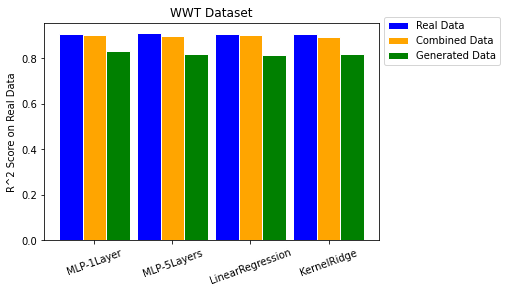

In [2]:
labels = ['MLP-1Layer', 'MLP-5Layers', 'LinearRegression', 'KernelRidge']
real = [0.9076, 0.9114, 0.90885, 0.908754]
combined = [0.9010,0.8991,0.90071,0.895775]
generated = [0.8316,0.8203,0.8132,0.8200]
x = np.arange(len(labels))  # the label locations
barWidth = 0.30  # the width of the bars

fig, ax = plt.subplots()

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('R^2 Score on Real Data')
ax.set_title('WWT Dataset')

# Set position of bar on X axis
r1 = np.arange(len(real))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, real, color='blue', width=barWidth, edgecolor='white', label='Real Data')
plt.bar(r2, combined, color='orange', width=barWidth, edgecolor='white', label='Combined Data')
plt.bar(r3, generated, color='green', width=barWidth, edgecolor='white', label='Generated Data')
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(real))], labels,rotation=20)
 
# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1, 1.05))
plt.savefig('WWT_Dataset.png',facecolor='white',dpi=160,bbox_to_anchor=(1, 1.05), bbox_inches='tight')
plt.show()
